In [2]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers;

C:\Users\marik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\marik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\marik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\marik\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [3]:
oc = []
column_names = ["n_tot", "ph_h2o", "oc"]
oc = pd.read_csv("C:/Users/marik/OneDrive/Documents/Organic.csv", usecols = column_names, skipinitialspace=True)
oc = oc.dropna()
len(oc);

### Introduction
#### Relationship between OC (Organic Carbon) and pH and nitrogen
When graphing OC versus other measurable factors like pH and nitrogen content it is impossible to get a clear relationship. When using real world agricultural data it is difficult to control variables and find a model when including many unrelated variables. Increasing the content organic carbon helps decrease atmospheric carbon dioxide as a form of carbon sequestration. Organic carbon itself is difficult to measure, as the most reliable method is through combustion in an industrial furnace. A model to predict organic carbon based on easily measurable variables can be useful to determine what agricultural practices contribute to organic carbon.

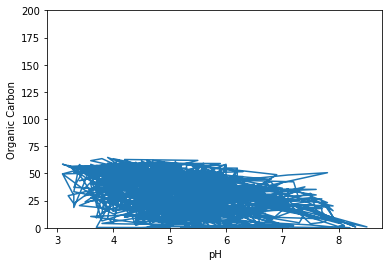

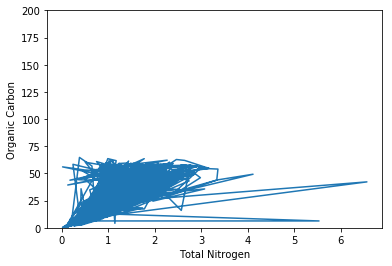

In [4]:
plt.figure()
plt.xlabel('pH')
plt.ylabel('Organic Carbon')
plt.plot(oc['ph_h2o'], oc['oc'])
plt.ylim([0, 200])
plt.show()

plt.figure()
plt.xlabel('Total Nitrogen')
plt.ylabel('Organic Carbon')
plt.plot(oc['n_tot'], oc['oc'])
plt.ylim([0, 200])
plt.show()

#### Database
The database comes from the NCSS (National Cooperative Soil Survey), an partnership between the USDA as well as state and local agencies to "cooperatively investigate, inventory, document, classify, interpret, disseminate, and publish information about soils."
#### Data used
The data used to train the model contains 853 rows. pH is measured in a 1:1 suspension of soil versus water. Organic Carbon and nitrogen are measured in % weight. According to the database: 
>Organic carbon is a measure of all organic forms of carbon in the soil, including organic carbon within minerals.

>The pH, 1:1 soil-water suspension is the pH of a sample measured in distilled water at a 1:1 soil:solution ratio. If wider ratios increase the pH, salts are indicated.

>The total (organic+inorganic) nitrogen in a sample supplies inferences on the soil potential to supply nitrogen to plants, and is used to determine C_N_RA and nitrogen distribution in a profile. It is reported as gravimetric percent on a <2 mm base.

In [5]:
train_dataset = oc.sample(frac=0.8,random_state=0)
test_dataset = oc.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("oc")
train_stats = train_stats.transpose()

In [6]:
train_labels = train_dataset.pop('oc')
test_labels = test_dataset.pop('oc')

### Machine Learning Model
#### Normalization
This model uses standard score normalization for the inputs, leaves the outputs un-normalized.
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/5fa4ed805c338486b0c852cca4b8e38ee9300870 "title")


In [7]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### Characteristics
The model is a simple regression deep neural network with backpropogation. It contains 2 hidden layers, and the input takes 2 values (nitrogen and pH), and returns 1 value (Organic Carbon). The model implements an early stop to learning once the change in loss becomes negligible.

In [8]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model();

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [9]:
# class PrintDot(keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs):
#     if epoch % 100 == 0: print('')
#     print('X', end='')


In [10]:
EPOCHS = 10000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop]);


Instructions for updating:
Use tf.cast instead.


In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

In [12]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2);
print(mse)

 - 0s - loss: 122.1185 - mean_absolute_error: 8.5772 - mean_squared_error: 122.1185
122.1185


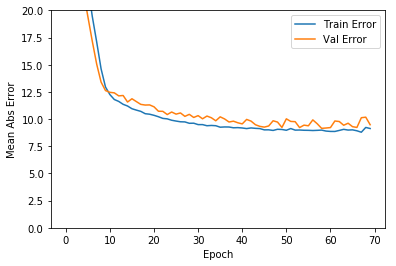

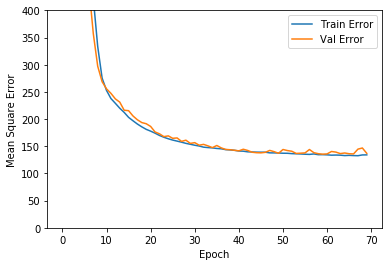

In [13]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,400])
  plt.legend()
  plt.show()


plot_history(history)


In [14]:
test_predictions = model.predict(normed_test_data)

#### Evaluation
Using only 853 rows of data and only 2 input variables does not create a reliable model. The graph of predicted values vs real values, however, shows a clear linear relationship. This simple model is a proof of concept of a more advanced neural network with more data and inputs.

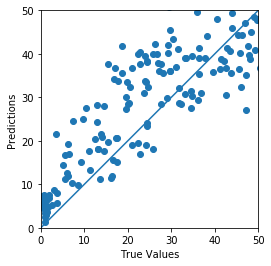

In [15]:


a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
